# Ensemble Learning & Random Forests

- Reading: 
    Geron, chapter 7

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

IMAGES_PATH = os.path.join(".", "images")

- Suppose you ask a complex question to thousands of random people, then aggregate
their answers. In many cases you will find that this aggregated answer is better than
an expert’s answer. This is called the **wisdom of the crowd**.
- Similarly, if you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor.
- A group of predictors is called an ensemble; thus, this technique is called **Ensemble Learning**, and an Ensemble Learning algorithm is called an Ensemble method.
- For example, you can train a group of Decision Tree classifiers, each on a different
random subset of the training set. To make predictions, you just obtain the predictions
of all individual trees, then predict the class that gets the most votes.
- Such an ensemble of Decision Trees is called a **Random Forest**, and despite its simplicity, this is one of the most powerful Machine Learning algorithms available today.
- The winning solutions in Machine Learning competitions often involve several Ensemble methods.

### Voting Classifiers

- Suppose you have trained a few classifiers, each one achieving about 80% accuracy.
- You may have a Logistic Regression classifier, an SVM classifier, a Random Forest classifier, a K-Nearest Neighbors classifier, and perhaps a few more.

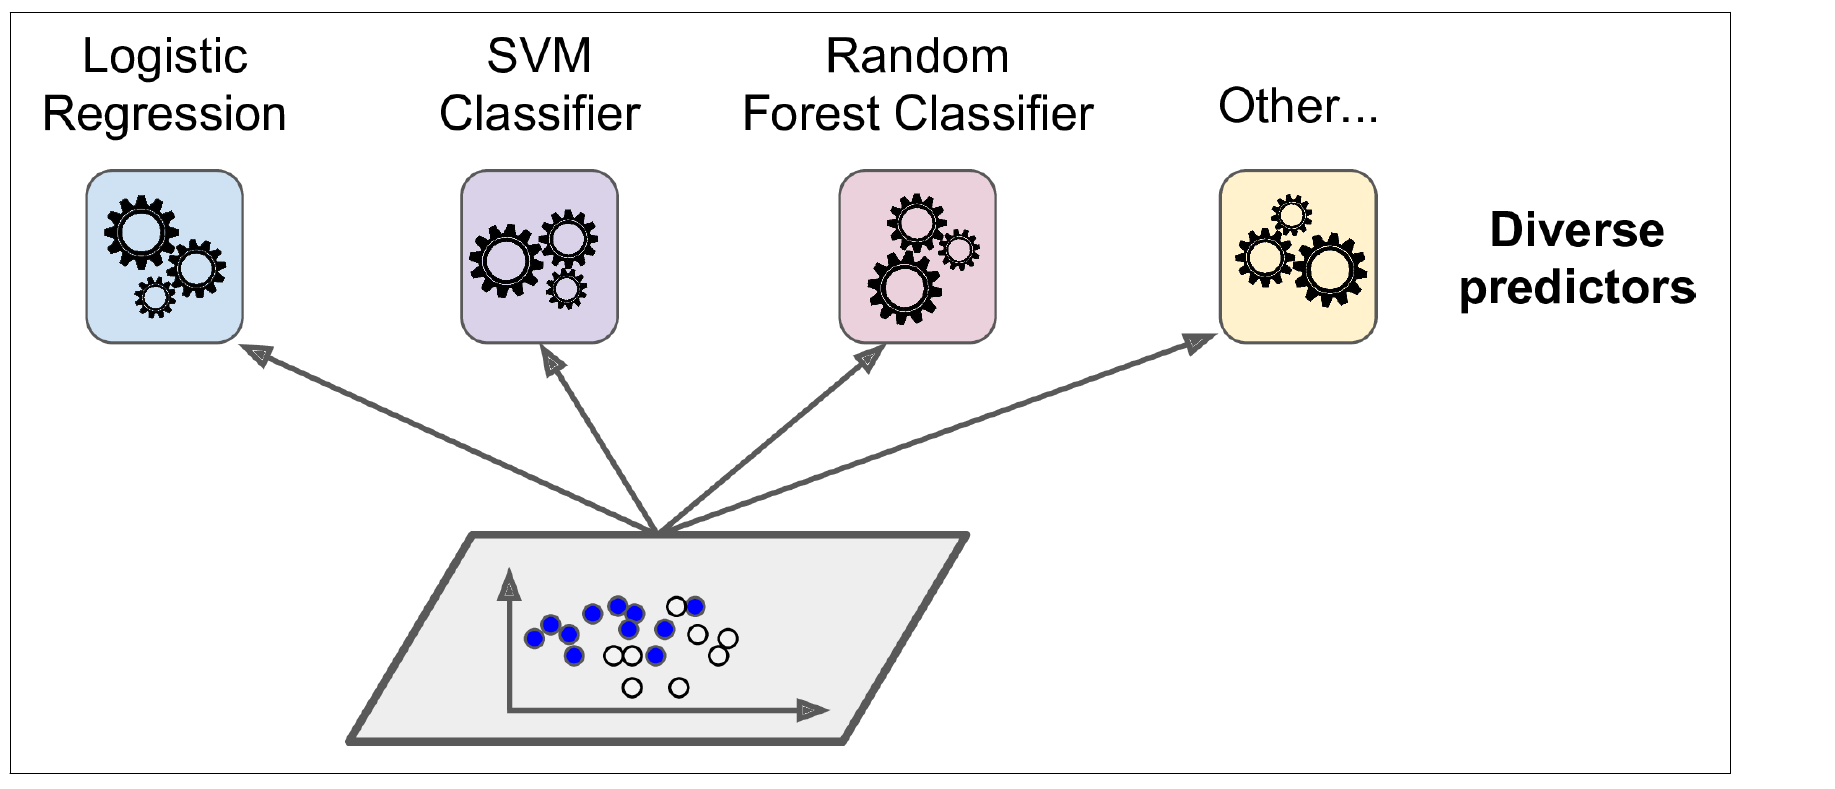

- A very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes.

- This majority-vote classifier is called a **hard voting classifier**.

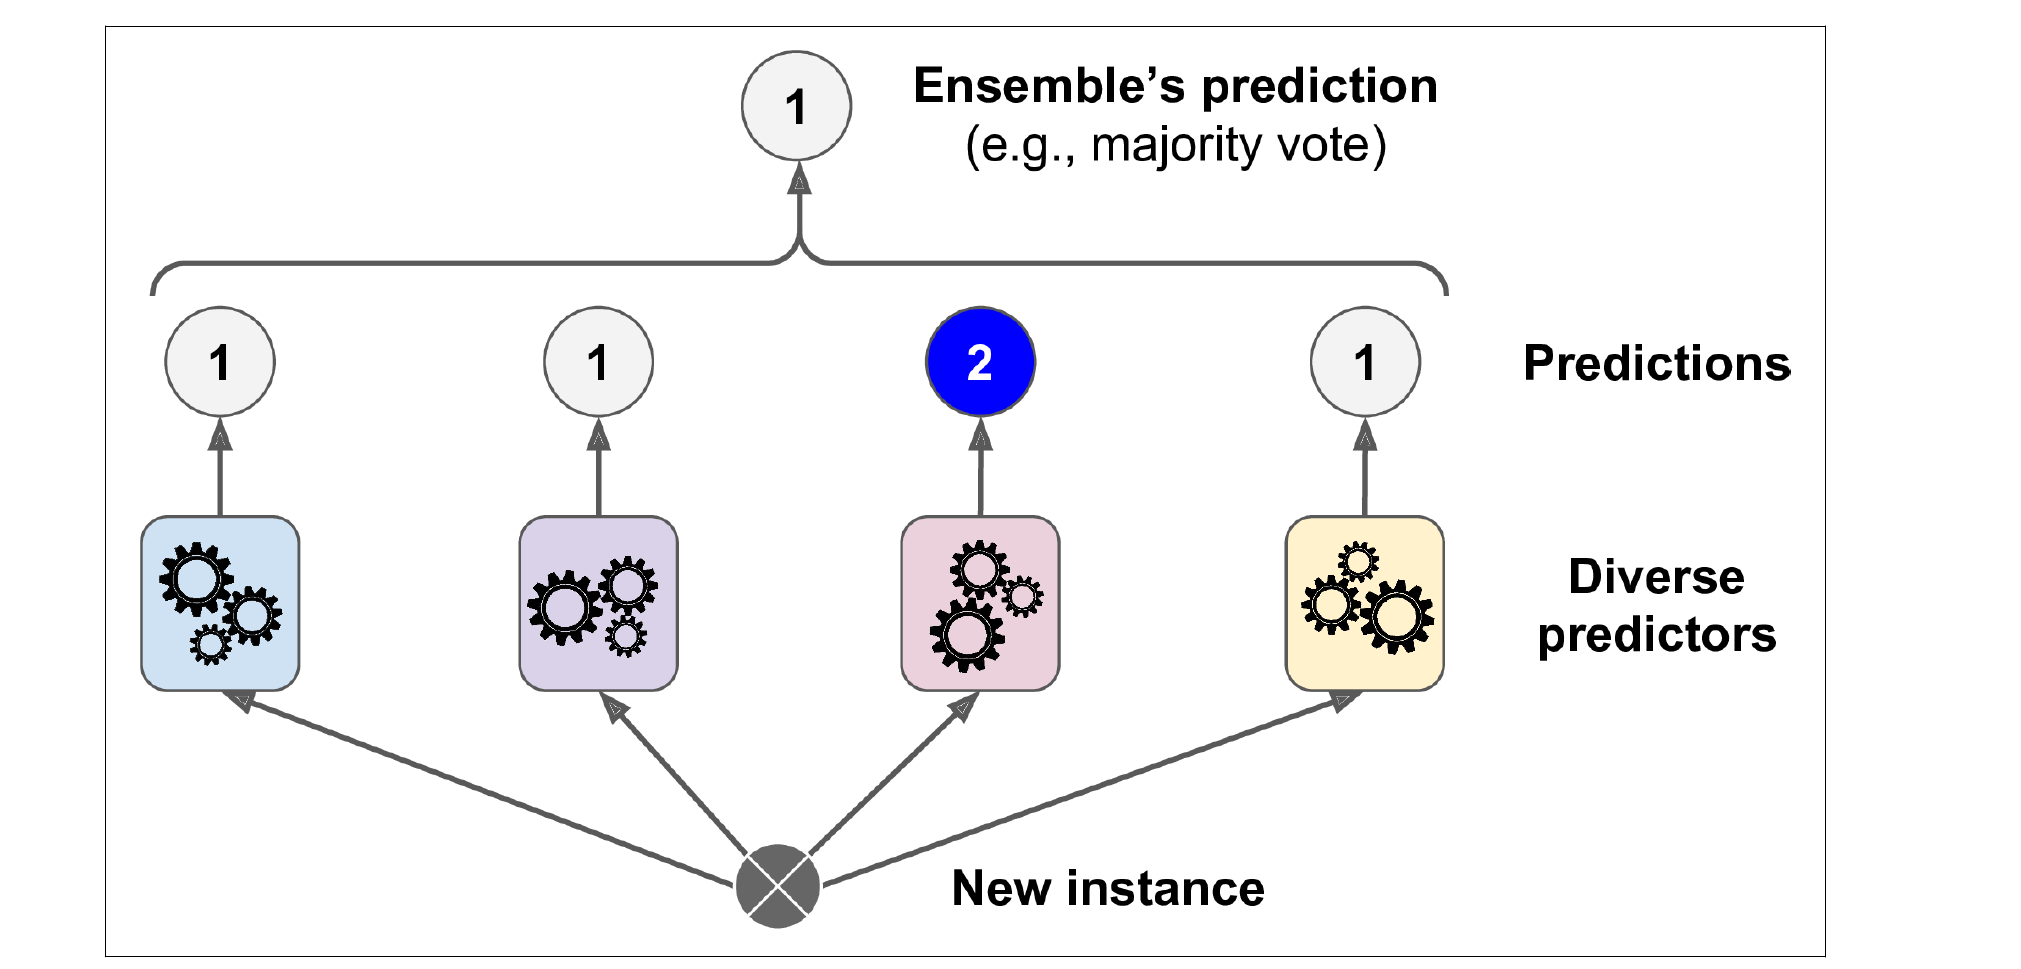

- Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the best classifier in the ensemble.
- In fact, even if each classifier is a weak learner (meaning it does only slightly better than random guessing), the ensemble can still be a strong learner (achieving high accuracy), provided there are a sufficient number of weak learners and they are sufficiently diverse.
- This is due to the **law of large numbers**:
    - Suppose you have a slightly biased coin that has a 51% chance of coming up heads. If you toss it 1,000 times, you will generally get more or less 510 heads and 490 tails, and hence a majority of heads.
    - As you keep tossing the coin, the ratio of heads gets closer and closer to the probability of heads (51%).
    - The figure below shows 10 series of biased coin tosses. As the number of tosses increases, the ratio of heads approaches 51%. Eventually all 10 series end up so close to 51% that they are consistently above 50%.
    
    

In [4]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) \
                        / np.arange(1, 10001).reshape(-1, 1)


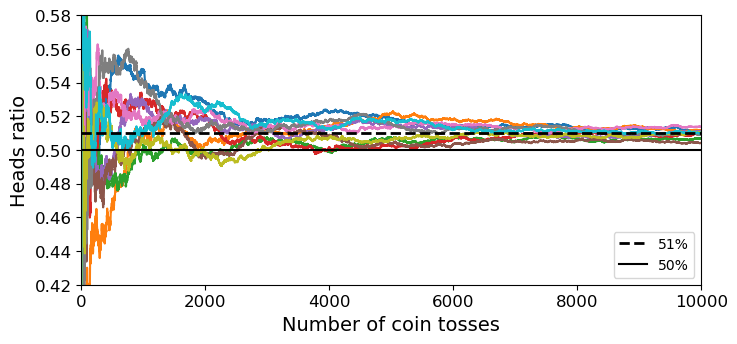

In [5]:
plt.figure(figsize=(8,3.5));
plt.plot(cumulative_heads_ratio);
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%");
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%");
plt.xlabel("Number of coin tosses");
plt.ylabel("Heads ratio");
plt.legend(loc="lower right");
plt.axis([0, 10000, 0.42, 0.58]);

plt.show();

- Suppose you build an ensemble containing 1,000 classifiers that are individually
correct only 51% of the time (barely better than random guessing).
- If you predict using the majority voted class, you can hope for up to 75% accuracy!
- However, this is **only true if all classifiers are perfectly independent, making uncorrelated errors**, which is clearly not the case since they are trained on the same data.
- The classifiers are likely to make the same types of errors, so there will be many majority votes for the wrong class, reducing the ensemble’s accuracy.

#### The following code creates and trains a voting classifier in Scikit-Learn, composed of three diverse classifiers (the training set is the moons dataset)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('logistic_reg', log_clf), ('random_forest', rnd_clf), ('svc', svm_clf)],
    voting='hard')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('logistic_reg',
                              LogisticRegression(random_state=42)),
                             ('random_forest',
                              RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [8]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression(random_state=42)

LogisticRegression 0.864


RandomForestClassifier(random_state=42)

RandomForestClassifier 0.896


SVC(random_state=42)

SVC 0.896


VotingClassifier(estimators=[('logistic_reg',
                              LogisticRegression(random_state=42)),
                             ('random_forest',
                              RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

VotingClassifier 0.912


#### Soft Voting

- If all classifiers are able to estimate class probabilities (i.e., they have a `predict_proba()` method), then you can tell Scikit-Learn to predict the class with the
highest class probability, averaged over all the individual classifiers.
- This is called soft voting. It often achieves higher performance than hard voting because it gives more weight to highly confident votes.

- All you need to do is replace voting="hard" with voting="soft" and ensure that all classifiers can estimate class probabilities.
    - This is not the case of the `SVC` class by default, so you need to set its probability hyperparameter to True (this will make the SVC class use cross-validation to estimate class probabilities, slowing down training, and it will add a predict_proba() method).

In [9]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [10]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression(random_state=42)

LogisticRegression 0.864


RandomForestClassifier(random_state=42)

RandomForestClassifier 0.896


SVC(probability=True, random_state=42)

SVC 0.896


VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

VotingClassifier 0.92


### Bagging and Pasting

- As we've seen, one way to get a diverse set of classifiers is to use very different training algorithms.
- **Another approach is to use the same training algorithm for every predictor, but to train them on different random subsets of the training set**.

- When sampling is performed with replacement, this method is called **bagging** (short for
bootstrap aggregating).
- When sampling is performed without replacement, it is called **pasting**.

In other words, both bagging and pasting allow training instances to be sampled several
times across multiple predictors, but only bagging allows training instances to be
sampled several times for the same predictor.

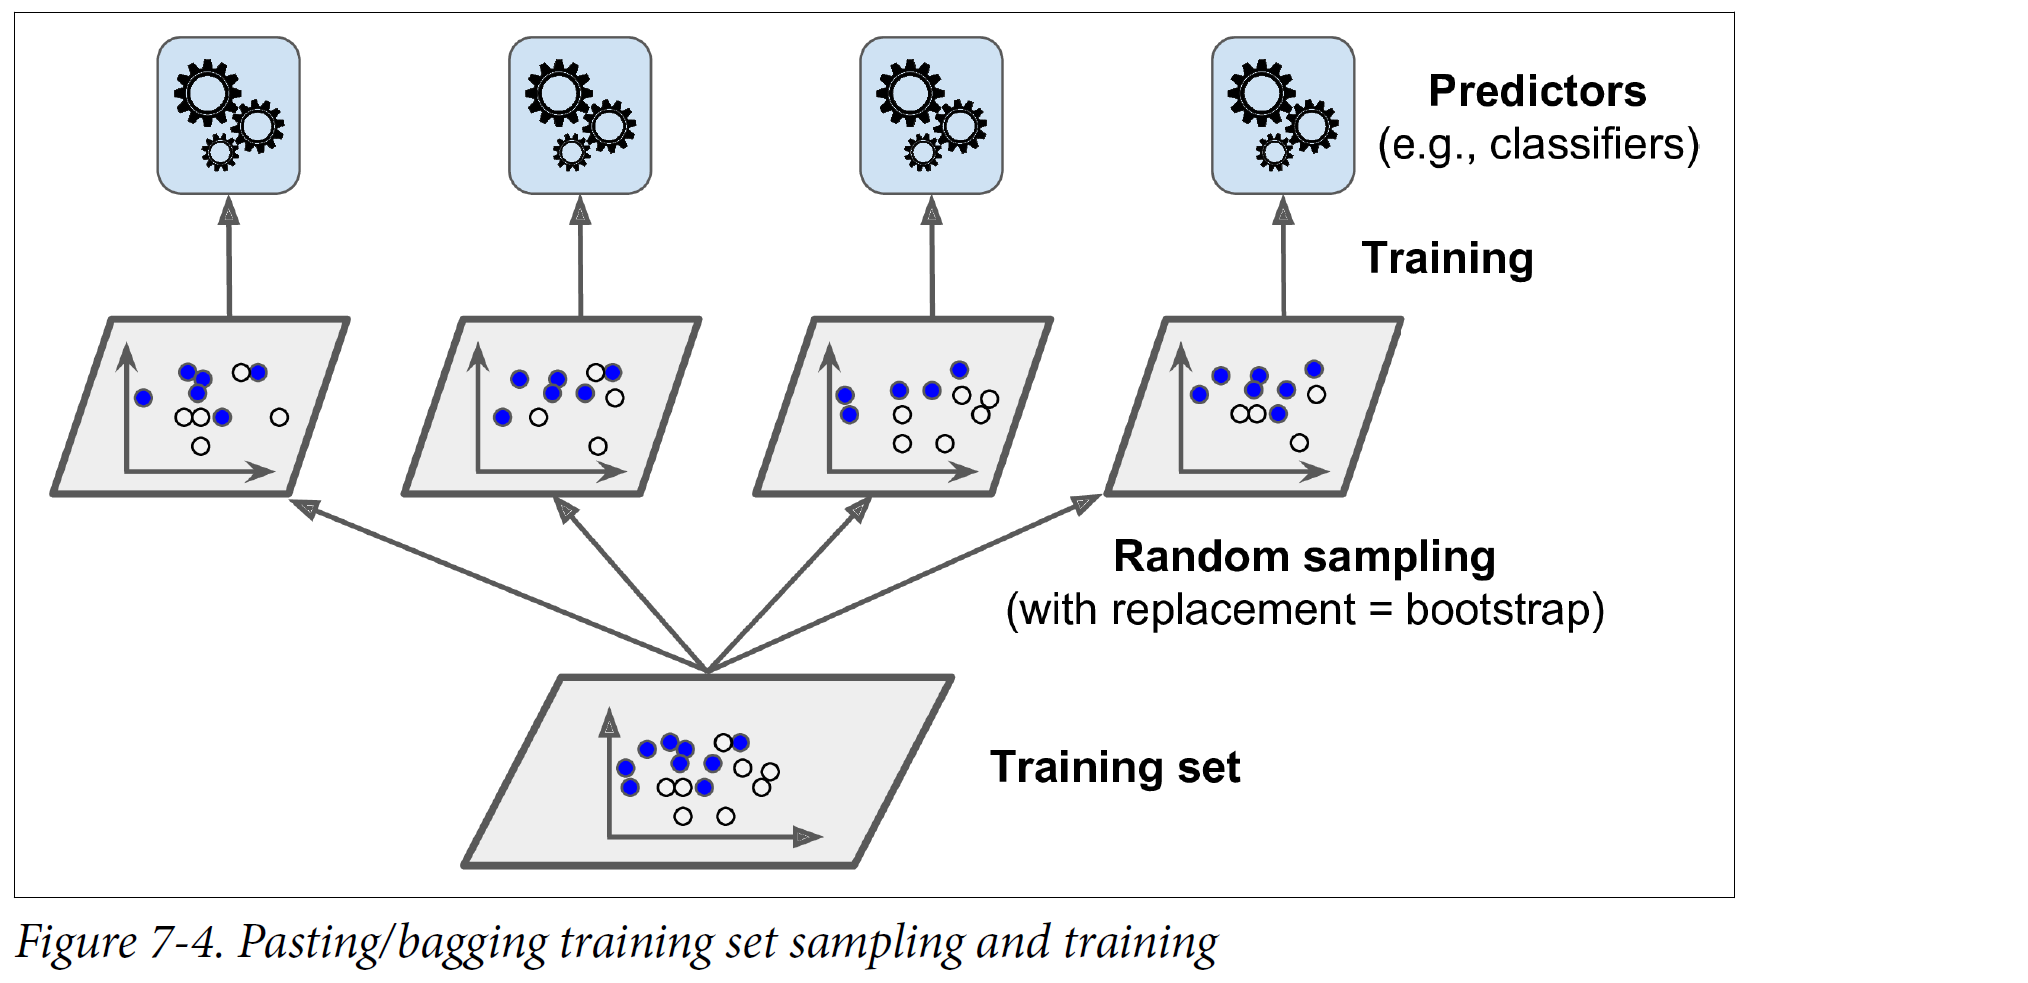

- Once all predictors are trained, the ensemble can make a prediction for a new
instance by simply aggregating the predictions of all predictors.
- The *aggregation function* is typically the statistical mode (i.e., the most frequent prediction, just like a hard voting classifier) for classification, or the average for regression.
- Each individual predictor has a *higher bias* than if it were trained on the original training set, **but aggregation reduces both bias and variance**. Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the original training set.
- Predictors can all be **trained in parallel**, via different CPU cores or even different servers. Similarly, predictions can be made in parallel. This is one of the reasons why bagging and pasting are such popular methods: they scale very well.

#### Scikit-Learn offers a simple API for both bagging and pasting with the `BaggingClassifier` class (or `BaggingRegressor` for regression).

- The following code trains an ensemble of 500 Decision Tree classifiers, 5 each trained on 100 training instances randomly sampled from the training set with replacement.
    - This is an example of bagging, but if you want to use pasting instead, just set `bootstrap=False`.
    - The `n_jobs` parameter tells Scikit-Learn the number of CPU cores to use for training and predictions (–1 tells Scikit-Learn to use all available cores)
    - The BaggingClassifier automatically performs soft voting instead of hard voting if the base classifier can estimate class probabilities (i.e., if it has a predict_proba() method), which is the case with Decision Trees classifiers.

In [11]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
            DecisionTreeClassifier(random_state=42),
            n_estimators=500,
            max_samples=100,
            bootstrap=True,
            random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_samples=100, n_estimators=500, random_state=42)

In [12]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [13]:
# For comparison, let's train a single Decision Tree on the entire training dataset
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

DecisionTreeClassifier(random_state=42)

0.856


The following figure compares the decision boundary of a single Decision Tree with the decision boundary of a bagging ensemble of 500 trees (from the preceding code), both
trained on the moons dataset.

In [14]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5],
                           alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

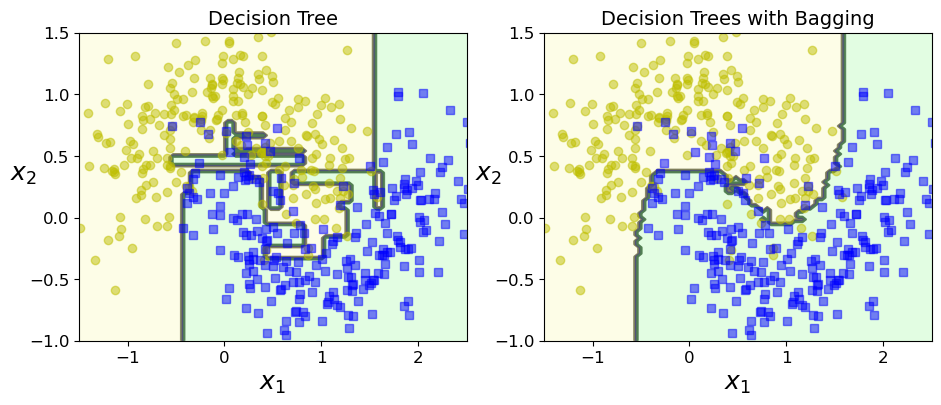

In [15]:
plt.figure(figsize=(11,4));
plt.subplot(121);
plot_decision_boundary(tree_clf, X, y);
plt.title("Decision Tree", fontsize=14);
plt.subplot(122);
plot_decision_boundary(bag_clf, X, y);
plt.title("Decision Trees with Bagging", fontsize=14);

plt.show();

The ensemble’s predictions will likely generalize much better than the single Decision Tree’s predictions: the ensemble has a comparable bias but a smaller variance (it makes roughly the same number of errors on the training set, but the decision boundary is less irregular).

#### To bootstrap or not to bootstrap

- Bootstrapping introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting.
- But this also means that predictors end up being less correlated so the ensemble’s variance is reduced.
- Overall, bagging often results in better models, which explains why it is generally preferred.
- However, if you have spare time and CPU power you can use crossvalidation to evaluate both bagging and pasting and select the one that works best.

#### Out-of-Bag Evaluation

- With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all.
- By default a `BaggingClassifier` samples $m$ training instances with replacement (bootstrap=True), where $m$ is the size of the training set.
- This means that only about $63\%$ of the training instances are sampled on
average for each predictor. The remaining $37\%$ of the training instances that are not
sampled are called **out-of-bag (oob)** instances (note that they are not the same $37\%$ for all predictors).

- Since a predictor never sees the **oob** instances during training, it can be evaluated on these instances, without the need for a separate validation set.
- You can evaluate the ensemble itself by averaging out the oob evaluations of each predictor.
- In Scikit-Learn, you can set `oob_score=True` when creating a `BaggingClassifier` to request an automatic oob evaluation after training.

In [16]:
bag_clf = BaggingClassifier(
            DecisionTreeClassifier(),
            n_estimators=500,
            bootstrap=True,
            n_jobs=-1,
            oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=500,
                  n_jobs=-1, oob_score=True)

0.8933333333333333

In [17]:
# According to this oob evaluation, this BaggingClassifier is likely to achieve about
# 90% accuracy on the test set. Let’s verify this:
    
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

- The oob decision function for each training instance is also available through the
`oob_decision_function_ variable`.
- In this case (since the base estimator has a `predict_proba() method`) the decision function returns the class probabilities for each training instance.

In [17]:
bag_clf.oob_decision_function_

array([[0.42857143, 0.57142857],
       [0.40782123, 0.59217877],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.06217617, 0.93782383],
       [0.36871508, 0.63128492],
       [0.00534759, 0.99465241],
       [0.99408284, 0.00591716],
       [0.96685083, 0.03314917],
       [0.77005348, 0.22994652],
       [0.01098901, 0.98901099],
       [0.82446809, 0.17553191],
       [0.81443299, 0.18556701],
       [0.95906433, 0.04093567],
       [0.05434783, 0.94565217],
       [0.00561798, 0.99438202],
       [0.98984772, 0.01015228],
       [0.96      , 0.04      ],
       [0.98989899, 0.01010101],
       [0.01117318, 0.98882682],
       [0.33507853, 0.66492147],
       [0.91160221, 0.08839779],
       [1.        , 0.        ],
       [0.97740113, 0.02259887],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.65608466, 0.34391534],
       [0.

### Random Patches and Random Subspaces

- The `BaggingClassifier` class supports sampling the features as well.
- This is controlled by two hyperparameters: `max_features` and `bootstrap_features`
- They work the same way as `max_samples` and `bootstrap`, but for feature sampling instead of instance sampling. Thus, each predictor will be trained on a random subset of the input features.
- This is particularly useful when you are dealing with high-dimensional inputs (such as images).

- Sampling both training instances and features is called the **Random Patches method**. - - Keeping all training instances (i.e., bootstrap=False and max_samples=1.0) but sampling features (i.e., bootstrap_features=True and/or max_features smaller than 1.0) is called the **Random Subspaces method**.
- Sampling features results in even more predictor diversity, trading a bit more bias for
a lower variance.


In [18]:
bag_clf = BaggingClassifier(
            DecisionTreeClassifier(),
            n_estimators=500,
            bootstrap=True,
            bootstrap_features=True,
            max_features=0.5,
            random_state=2)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                  bootstrap_features=True, max_features=0.5, n_estimators=500,
                  random_state=2)

0.824

### Random Forests

A **Random Forest** is an ensemble of Decision Trees, generally trained via the bagging method (or sometimes pasting), typically with max_samples set to the size of the training set.

- Instead of building a `BaggingClassifier` and passing it a `DecisionTreeClassifier`, you can instead use the `RandomForestClassifier` class, which is more convenient and optimized for Decision Trees.
- Similarly, there is a `RandomForestRegressor` class for regression tasks.

- The following code trains a Random Forest classifier with 500 trees (each limited to maximum 16 nodes), using all available CPU cores:

In [19]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(
            n_estimators=500,
            max_leaf_nodes=16,
            random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, random_state=42)

In [19]:
# Random Forest via BaggingClasifier

bag_clf = BaggingClassifier(
            DecisionTreeClassifier(
                splitter="random",
                max_leaf_nodes=16,
                random_state=42),
            n_estimators=500,
            max_samples=1.0,
            bootstrap=True,
            random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='random'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=500, n_jobs=None, oob_score=False,
         random_state=42, verbose=0, warm_start=False)

In [20]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

0.976

- The Random Forest algorithm introduces extra randomness when growing trees.
- Instead of searching for the very best feature when splitting a node, it searches for the best feature among a **random subset of features**.
- This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model.

### Extra-Trees

- It is possible to make trees **even more random** by also using random thresholds for each feature rather than searching for the best possible thresholds (like regular Decision Trees do).
- A forest of such extremely random trees is simply called an **Extremely Randomized Trees ensemble** (or **Extra-Trees** for short).

- Once again, this trades more bias for a lower variance.
- It also makes Extra-Trees much faster to train than regular Random Forests since finding the best possible threshold for each feature at every node is one of the most time-consuming tasks of growing a tree.

- You can create an Extra-Trees classifier using Scikit-Learn’s `ExtraTreesClassifier` class. Its API is identical to the `RandomForestClassifier` class.
- Similarly, the `ExtraTreesRegressor` class has the same API as the `RandomForestRegressor` class.

In [21]:
from sklearn.ensemble import ExtraTreesClassifier

extra_clf = ExtraTreesClassifier(
            n_estimators=500,
            max_leaf_nodes=16,
            random_state=42)
extra_clf.fit(X_train, y_train)

y_pred_xt = extra_clf.predict(X_test)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=16,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [22]:
accuracy_score(y_test, y_pred_xt)

0.912

### Feature Importance

- Yet another great quality of Random Forests is that they make it easy to measure the relative importance of each feature.
- Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest).
- More precisely, it is a weighted average, where each node’s weight is equal to the number of training samples that are associated with it.

- Scikit-Learn computes this score automatically for each feature after training, then it scales the results so that the sum of all importances is equal to 1.
- You can access the result using the `feature_importances_` variable.

In [23]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

sepal length (cm) 0.11249225099876374
sepal width (cm) 0.023119288282510326
petal length (cm) 0.44103046436395765
petal width (cm) 0.4233579963547681


Similarly, if you train a Random Forest classifier on the MNIST dataset and plot each pixel’s importance:

In [24]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

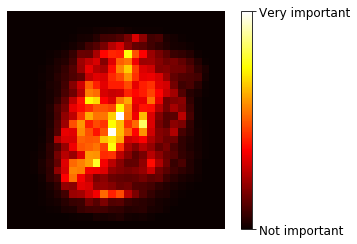

In [25]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest");
    plt.axis("off");
    
plot_digit(rnd_clf.feature_importances_);

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show();

#### Random Forests are very handy to get a quick understanding of what features actually matter, in particular if you need to perform feature selection.

### Boosting

- Boosting refers to any Ensemble method that can combine several weak learners into a strong learner.
- The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor.
- There are many boosting methods available, but by far the most popular are **AdaBoost** (short for Adaptive Boosting) and **Gradient Boosting**.

### AdaBoost

- One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted.
- This results in new predictors focusing more and more on the hard cases. This is the technique used by AdaBoost.
    - For example, to build an AdaBoost classifier, a first base classifier (such as a Decision Tree) is trained and used to make predictions on the training set.
    - The relative weight of misclassified training instances is then increased.
    - A second classifier is trained using the updated weights and again it makes predictions on the training set, weights are updated, and so on.
    
    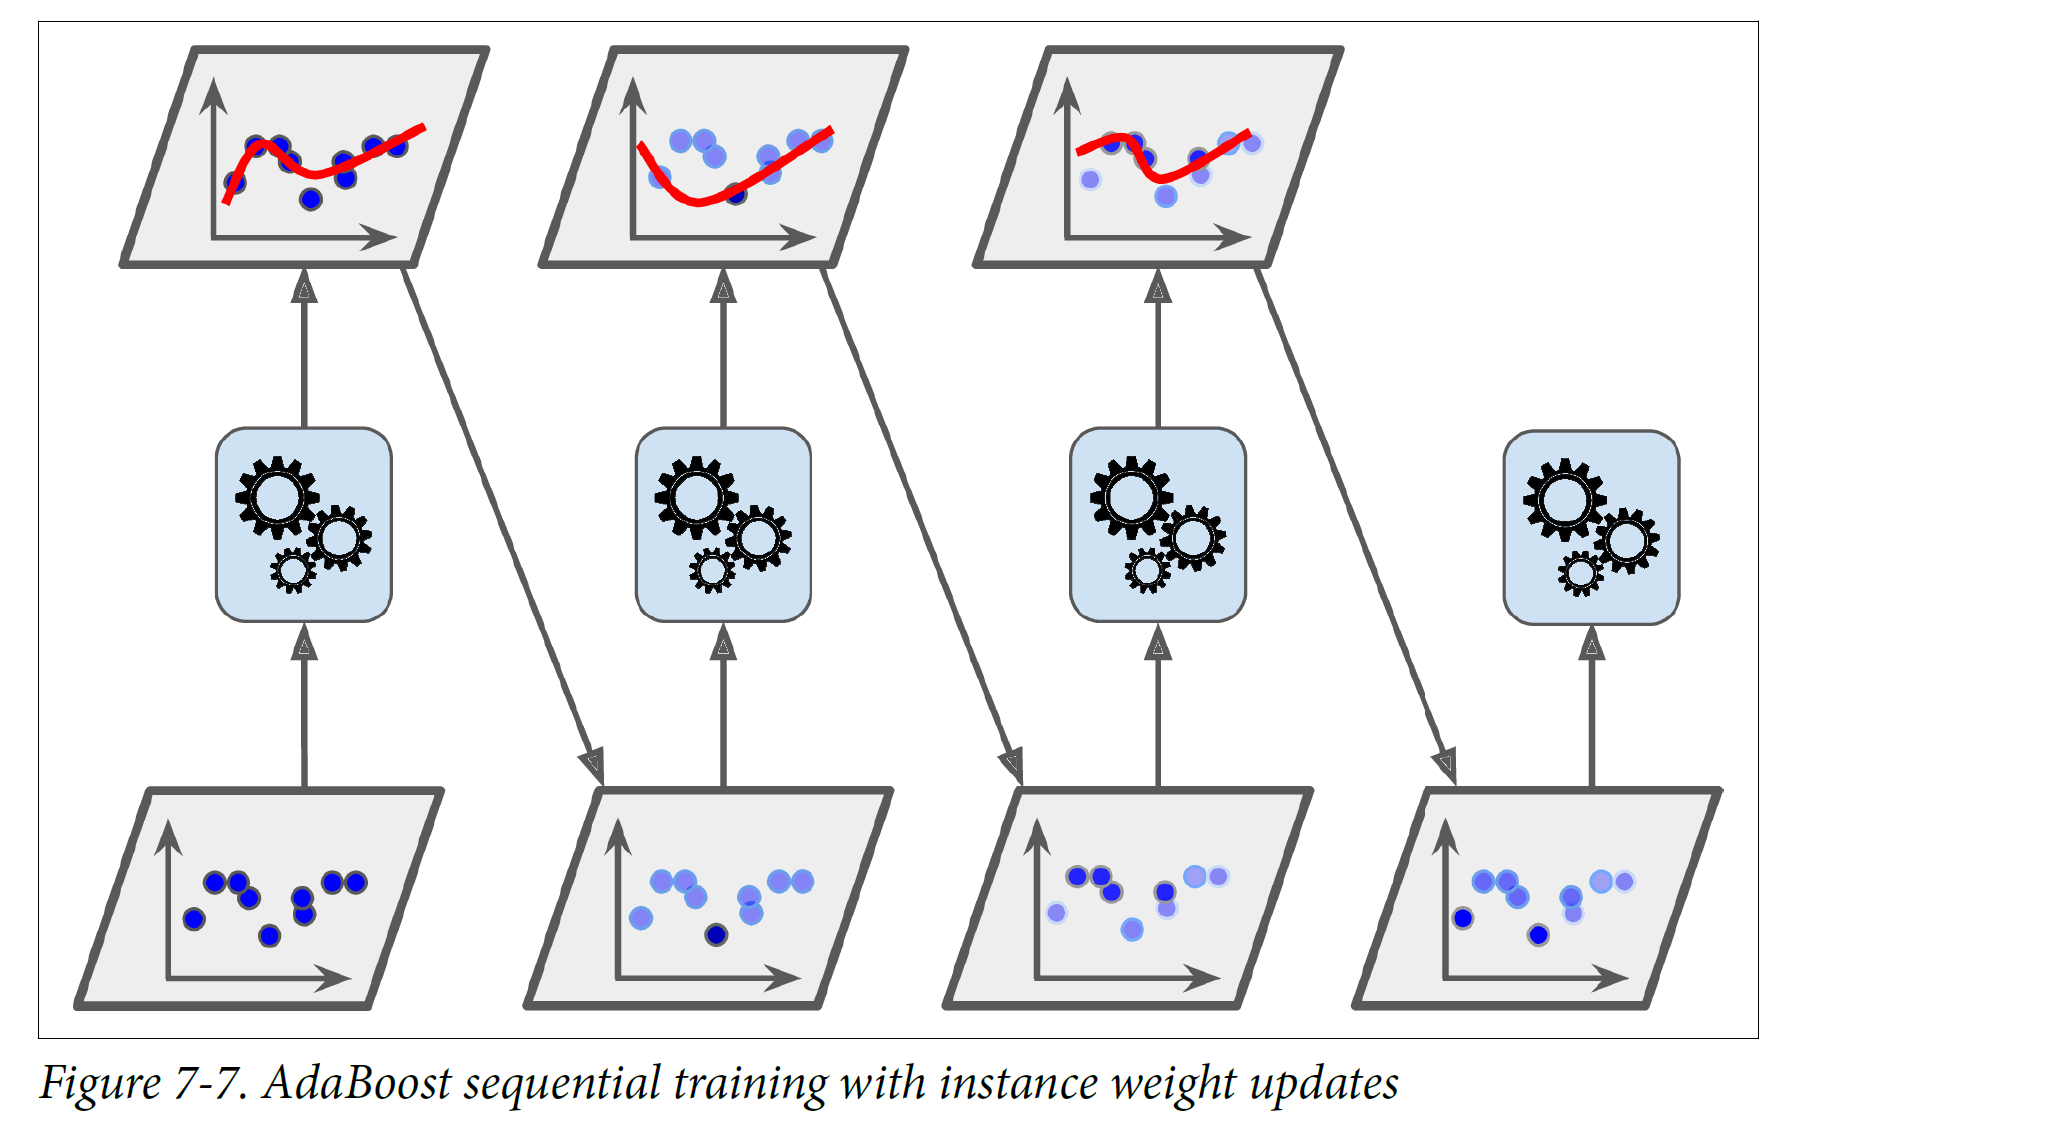

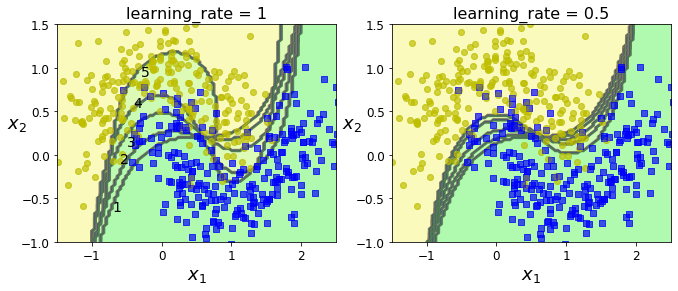

In [26]:
# Adaboost done by hand

m = len(X_train)

plt.figure(figsize=(11, 4));
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)      # Define sample weights
    plt.subplot(subplot);
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)   # sample_weight!
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)   # update weights
        plot_decision_boundary(svm_clf, X, y, alpha=0.2);
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16);
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14);
        plt.text(-0.6, -0.10, "2", fontsize=14);
        plt.text(-0.5,  0.10, "3", fontsize=14);
        plt.text(-0.4,  0.55, "4", fontsize=14);
        plt.text(-0.3,  0.90, "5", fontsize=14);


plt.show();

- Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that predictors have different weights depending on their overall accuracy on the weighted training set.
- There is one important drawback to this sequential learning technique: it cannot be parallelized (or only partially), since each predictor can only be trained after the previous predictor has been trained and evaluated. As a result, it does not scale as well as bagging or pasting.

- Let’s take a closer look at the AdaBoost algorithm:
    
    - Each instance weight w(i) is initially set to $1/m$.
    
    - A predictor is trained and its weighted error rate $r_j$ is computed on the training set.
    
    $$r_j = \frac{ \sum_{\hat{y}_j^{(i)}\neq y^{(i)}} w^{(i)} }{\sum_{i=1}^m w^{(i)}}$$
    
    - The predictor’s weight $\alpha_j$ is then computed, where $\eta$ is the learning rate hyperparameter (defaults to 1).
    
    $$\alpha_j = \eta \log\left(\frac{1-r_j}{r_j}\right)$$
    
    - The more accurate the predictor is, the higher its weight will be. If it is just guessing randomly, then its weight will be close to zero. However, if it is most often wrong (i.e., less accurate than random guessing), then its weight will be negative.
    
    - Next the instance weights are updated, so the misclassified instances are boosted:
    $$w^{(i)} \leftarrow 
        \begin{cases}
            w^{(i)} \quad\quad\quad\quad \text{if  } \hat{y_j}^{(i)}=y^{(i)} \\
            w^{(i)}\exp(\alpha_j)\quad \text{if  } \hat{y_j}^{(i)}\neq y^{(i)}\\
        \end{cases}$$
        
    - Then all the instance weights are normalized (i.e., divided by $\sum_{i=1}^m w^{(i)}$).
    
    - Finally, the whole process is repeated (a new predictor is trained using the updated weights, the new predictor’s weight is computed, the instance weights are updated, then another predictor is trained, and so on).
    
    - The algorithm stops when the desired number of predictors is reached, or when a perfect predictor is found.

To make predictions, AdaBoost simply computes the predictions of all the predictors
and weighs them using the predictor weights $\alpha_j$. The predicted class is the one that
receives the majority of weighted votes.

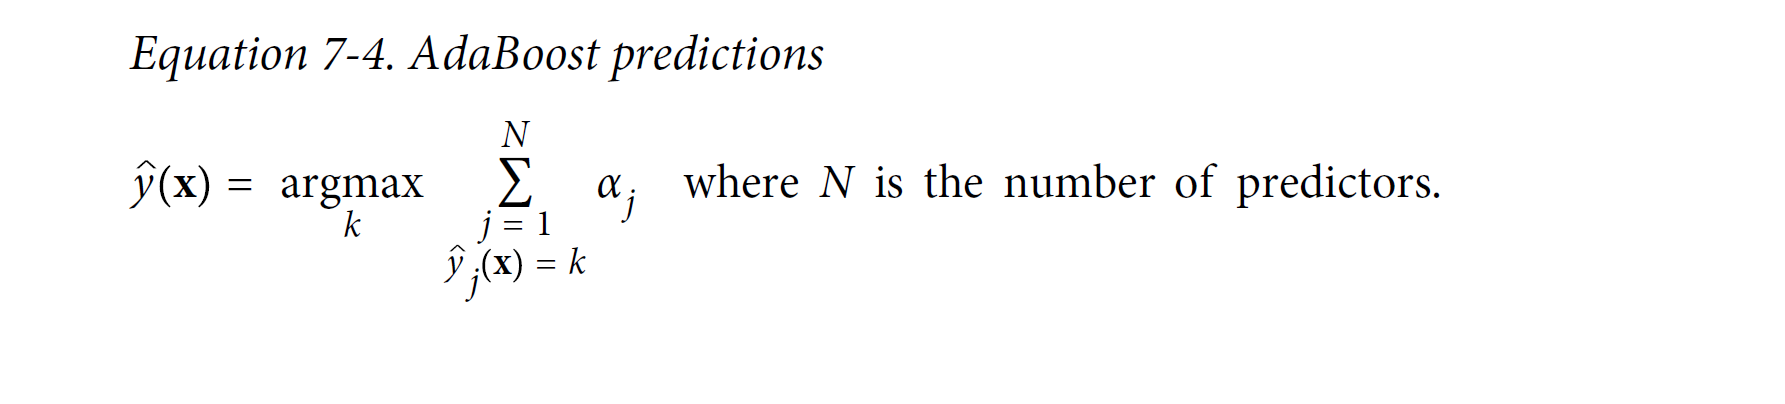

- Scikit-Learn actually uses a multiclass version of AdaBoost called `SAMME` (which
stands for Stagewise Additive Modeling using a Multiclass Exponential loss function).

- When there are just two classes, SAMME is equivalent to AdaBoost.
- Moreover, if thepredictors can estimate class probabilities (i.e., if they have a predict_proba() method), Scikit-Learn can use a variant of SAMME called SAMME.R (the R stands for “Real”), which relies on class probabilities rather than predictions and generally performs better.

- The following code trains an AdaBoost classifier based on 200 **Decision Stumps** using
Scikit-Learn’s `AdaBoostClassifier` class (as you might expect, there is also an 
`AdaBoostRegressor` class).
- A Decision Stump is a Decision Tree with `max_depth=1` — in other words, a tree composed of a single decision node plus two leaf nodes. This is the default base estimator for the AdaBoostClassifier class:

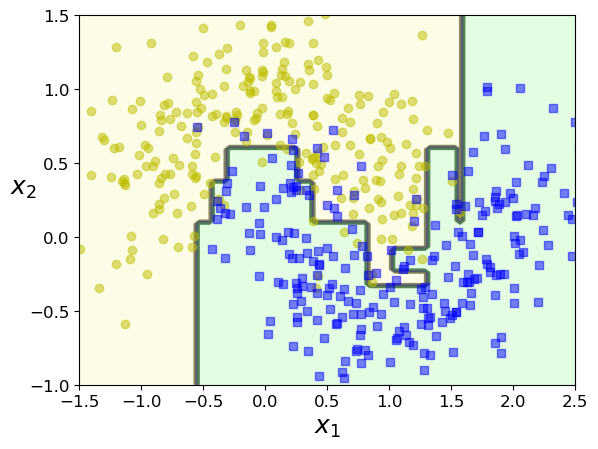

In [12]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
            DecisionTreeClassifier(max_depth=1),
            n_estimators=50,
            algorithm="SAMME.R",
            learning_rate=0.5, random_state=42)

ada_clf.fit(X_train, y_train)
plot_decision_boundary(ada_clf, X, y);

### Gradient Boosting

- Another very popular Boosting algorithm is Gradient Boosting.
- Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor.
- However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to **fit the new predictor to the residual errors made by the previous predictor**.


Let’s fit a DecisionTreeRegressor to a noisy quadratic training set:

In [13]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

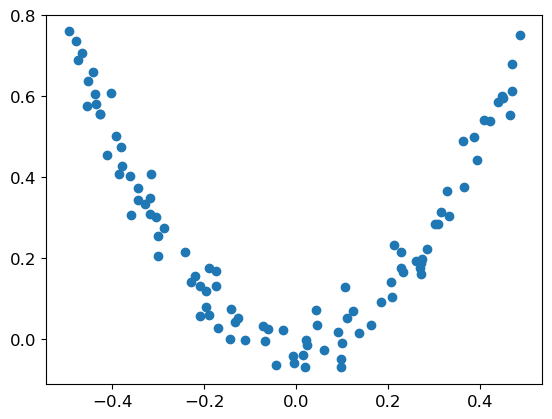

In [14]:
plt.scatter(X, y)

In [15]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [16]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [17]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) 
             for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

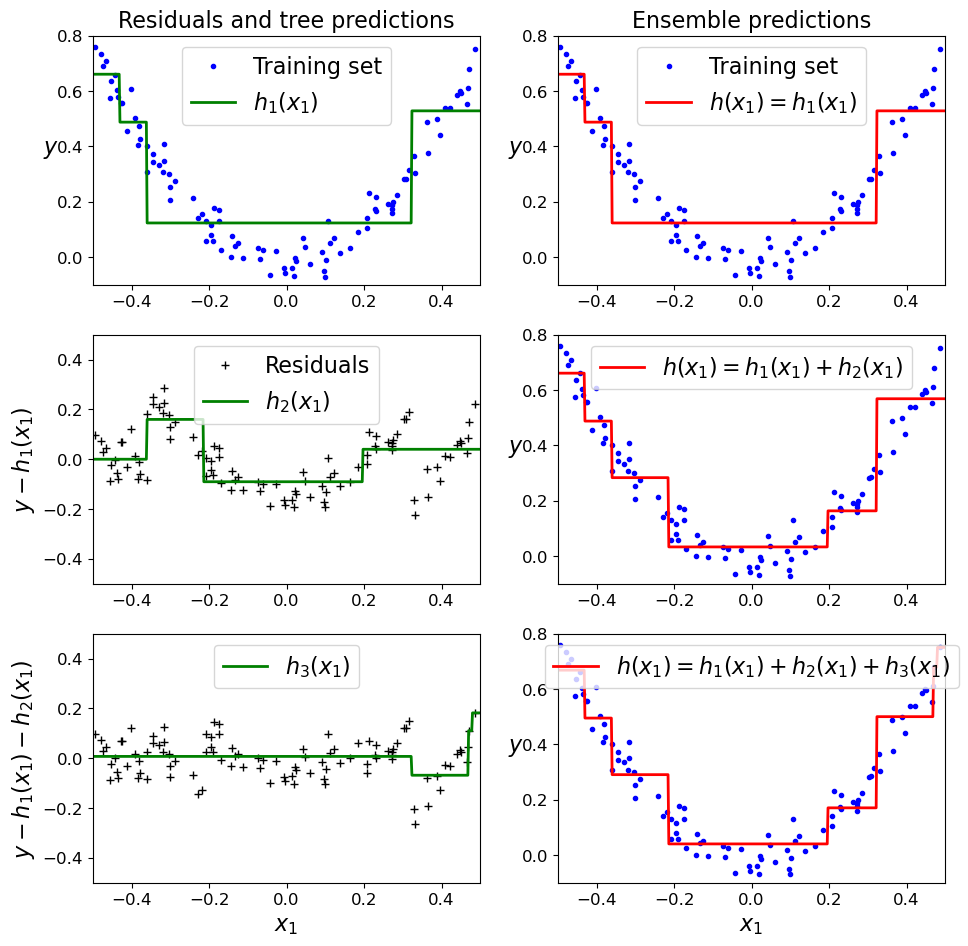

In [18]:
def plot_predictions(regressors, X, y, axes, label=None,
                     style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label);
    plt.plot(x1, y_pred, style, linewidth=2, label=label);
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16);
    plt.axis(axes);
    
plt.figure(figsize=(11,11));

plt.subplot(321);
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8],
                 label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0);
plt.title("Residuals and tree predictions", fontsize=16);

plt.subplot(322);
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8],
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set");
plt.ylabel("$y$", fontsize=16, rotation=0);
plt.title("Ensemble predictions", fontsize=16);

plt.subplot(323);
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5],
                 label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals");
plt.ylabel("$y - h_1(x_1)$", fontsize=16);

plt.subplot(324);
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8],
                 label="$h(x_1) = h_1(x_1) + h_2(x_1)$");
plt.ylabel("$y$", fontsize=16, rotation=0);

plt.subplot(325);
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5],
                 label="$h_3(x_1)$", style="g-", data_style="k+");
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16);
plt.xlabel("$x_1$", fontsize=16);

plt.subplot(326);
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8],
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16);
plt.ylabel("$y$", fontsize=16, rotation=0);

plt.show();

* In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions.
* In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees.
* In the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.

A simpler way to train GBRT ensembles is to use Scikit-Learn’s `GradientBoostingRegressor` class.

- Much like the `RandomForestRegressor` class, it has hyperparameters to
control the growth of Decision Trees (e.g., `max_depth`, `min_samples_leaf`, and so on),
as well as hyperparameters to control the ensemble training, such as the number of
trees (`n_estimators`).

- The `learning_rate` hyperparameter scales the contribution of each tree.
- If you set it to a low value, such as 0.1, you will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better. This is a regularization technique called *shrinkage*.

In [19]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2,
                                 n_estimators=3,
                                 learning_rate=1.0,
                                 random_state=42)
gbrt.fit(X, y)

gbrt_slow = GradientBoostingRegressor(max_depth=2,
                                      n_estimators=200,
                                      learning_rate=0.1,
                                      random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

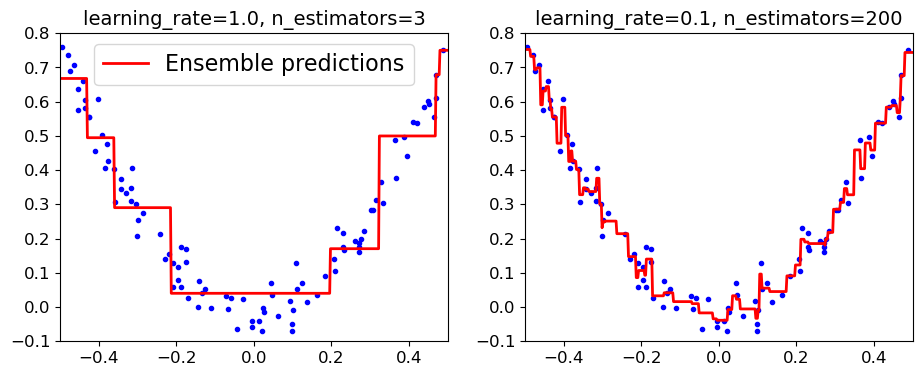

In [20]:
plt.figure(figsize=(11,4));

plt.subplot(121);
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8],
                 label="Ensemble predictions");
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate,
                                                     gbrt.n_estimators), fontsize=14);

plt.subplot(122);
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8]);
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate,
                                                     gbrt_slow.n_estimators), fontsize=14);

plt.show();

#### Gradient Boosting with Early stopping

- In order to find the optimal number of trees, you can use *early stopping*.
- A simple way to implement this is to use the `staged_predict()` method: it returns an iterator over the predictions made by the ensemble at each stage of training (with one tree, two trees, etc.).

In [22]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Get a validation set
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                 random_state=49)

# Specify a large number of stages
gbrt = GradientBoostingRegressor(max_depth=2,
                                 n_estimators=120,
                                 random_state=42)
gbrt.fit(X_train, y_train)

# get the MSE by stage
errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]

bst_n_estimators = np.argmin(errors) + 1

# Pick the best!
gbrt_best = GradientBoostingRegressor(max_depth=2,
                                      n_estimators=bst_n_estimators,
                                      random_state=42)
gbrt_best.fit(X_train, y_train)
min_error = np.min(errors)

GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

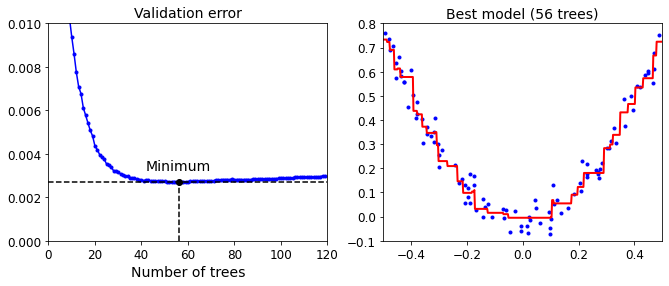

In [12]:
plt.figure(figsize=(11, 4));

plt.subplot(121);
plt.plot(errors, "b.-");
# Mark the best estimator
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--");
plt.plot([0, 120], [min_error, min_error], "k--");
plt.plot(bst_n_estimators, min_error, "ko");
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14);

plt.axis([0, 120, 0, 0.01]);
plt.xlabel("Number of trees");
plt.title("Validation error", fontsize=14);

plt.subplot(122);
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8]);
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14);

plt.show();

- It is also possible to implement early stopping by actually stopping training early (instead of training a large number of trees first and then looking back to find the optimal number).

- You can do so by setting `warm_start=True`, which makes Scikit-Learn keep existing trees when the fit() method is called, allowing incremental training.

- The following code stops training when the validation error does not improve for five iterations in a row.

In [23]:
gbrt = GradientBoostingRegressor(max_depth=2,
                                 warm_start=True,
                                 random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    # Manually set the number of trees
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    # Get validation error
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    # check if minimum attained
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    # else increase count and check if max reached
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping
            

GradientBoostingRegressor(max_depth=2, n_estimators=1, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=2, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=3, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=4, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=5, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=6, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=7, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=8, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=9, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=10, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=11, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=12, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=13, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=14, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=15, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=16, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=17, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=18, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=19, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=20, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=21, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=22, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=23, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=24, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=25, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=26, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=27, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=28, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=29, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=30, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=31, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=32, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=33, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=34, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=35, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=36, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=37, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=38, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=39, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=40, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=41, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=42, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=43, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=44, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=45, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=46, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=47, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=48, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=49, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=50, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=51, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=52, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=53, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=54, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=55, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=57, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=58, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=59, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=60, random_state=42,
                          warm_start=True)

GradientBoostingRegressor(max_depth=2, n_estimators=61, random_state=42,
                          warm_start=True)

In [24]:
print(gbrt.n_estimators-5)
print("Minimum validation MSE:", min_val_error)

56
Minimum validation MSE: 0.002712853325235463


- The GradientBoostingRegressor class also supports a `subsample` hyperparameter,
which specifies the fraction of training instances to be used for training each tree.
- For example, if `subsample=0.25`, then each tree is trained on 25% of the training instances, selected randomly. This trades a higher bias for a lower variance. It also speeds up training considerably.
- This technique is called **Stochastic Gradient Boosting**.


#### Using XGBoost

- An optimized implementation of Gradient Boosting is available in the popular python library `XGBoost`, which stands for *Extreme Gradient Boosting*.



In [25]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

Error: the xgboost library is not installed.


In [42]:
xgb_reg = xgboost.XGBRegressor(random_state=42,
                               max_depth=2,
                               objective='reg:squarederror')
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred) 
print("Validation MSE:", val_error)           

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

Validation MSE: 0.0029403473693455236


In [43]:
# Early stopping
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=5)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred) 
print("Validation MSE:", val_error)            

[0]	validation_0-rmse:0.23130
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:0.16785
[2]	validation_0-rmse:0.12560
[3]	validation_0-rmse:0.09873
[4]	validation_0-rmse:0.08182
[5]	validation_0-rmse:0.07418
[6]	validation_0-rmse:0.06240
[7]	validation_0-rmse:0.05888
[8]	validation_0-rmse:0.05758
[9]	validation_0-rmse:0.05351
[10]	validation_0-rmse:0.05374
[11]	validation_0-rmse:0.05426
[12]	validation_0-rmse:0.05277
[13]	validation_0-rmse:0.05246
[14]	validation_0-rmse:0.05265
[15]	validation_0-rmse:0.05316
[16]	validation_0-rmse:0.05250
[17]	validation_0-rmse:0.05233
[18]	validation_0-rmse:0.05249
[19]	validation_0-rmse:0.05248
[20]	validation_0-rmse:0.05219
[21]	validation_0-rmse:0.05246
[22]	validation_0-rmse:0.05228
[23]	validation_0-rmse:0.05161
[24]	validation_0-rmse:0.05165
[25]	validation_0-rmse:0.05162
[26]	validation_0-rmse:0.05149
[27]	validation_0-rmse:0.05148
[28]	validation_0-rmse:0.05146
[29]	validation_0-rmse:0.05151
[30]	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

Validation MSE: 0.0026480716953022456


In [44]:
%timeit xgboost.XGBRegressor(max_depth=2, objective='reg:squarederror').fit(X_train, y_train)

15.6 ms ± 978 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [45]:
%timeit GradientBoostingRegressor(max_depth=2).fit(X_train, y_train)

10.5 ms ± 188 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Stacking

- Stacking is short for **stacked generalization**
- It is based on a simple idea: instead of using trivial functions (such as hard voting) to aggregate the predictions of all predictors in an ensemble, why don’t we train a model to perform this aggregation?

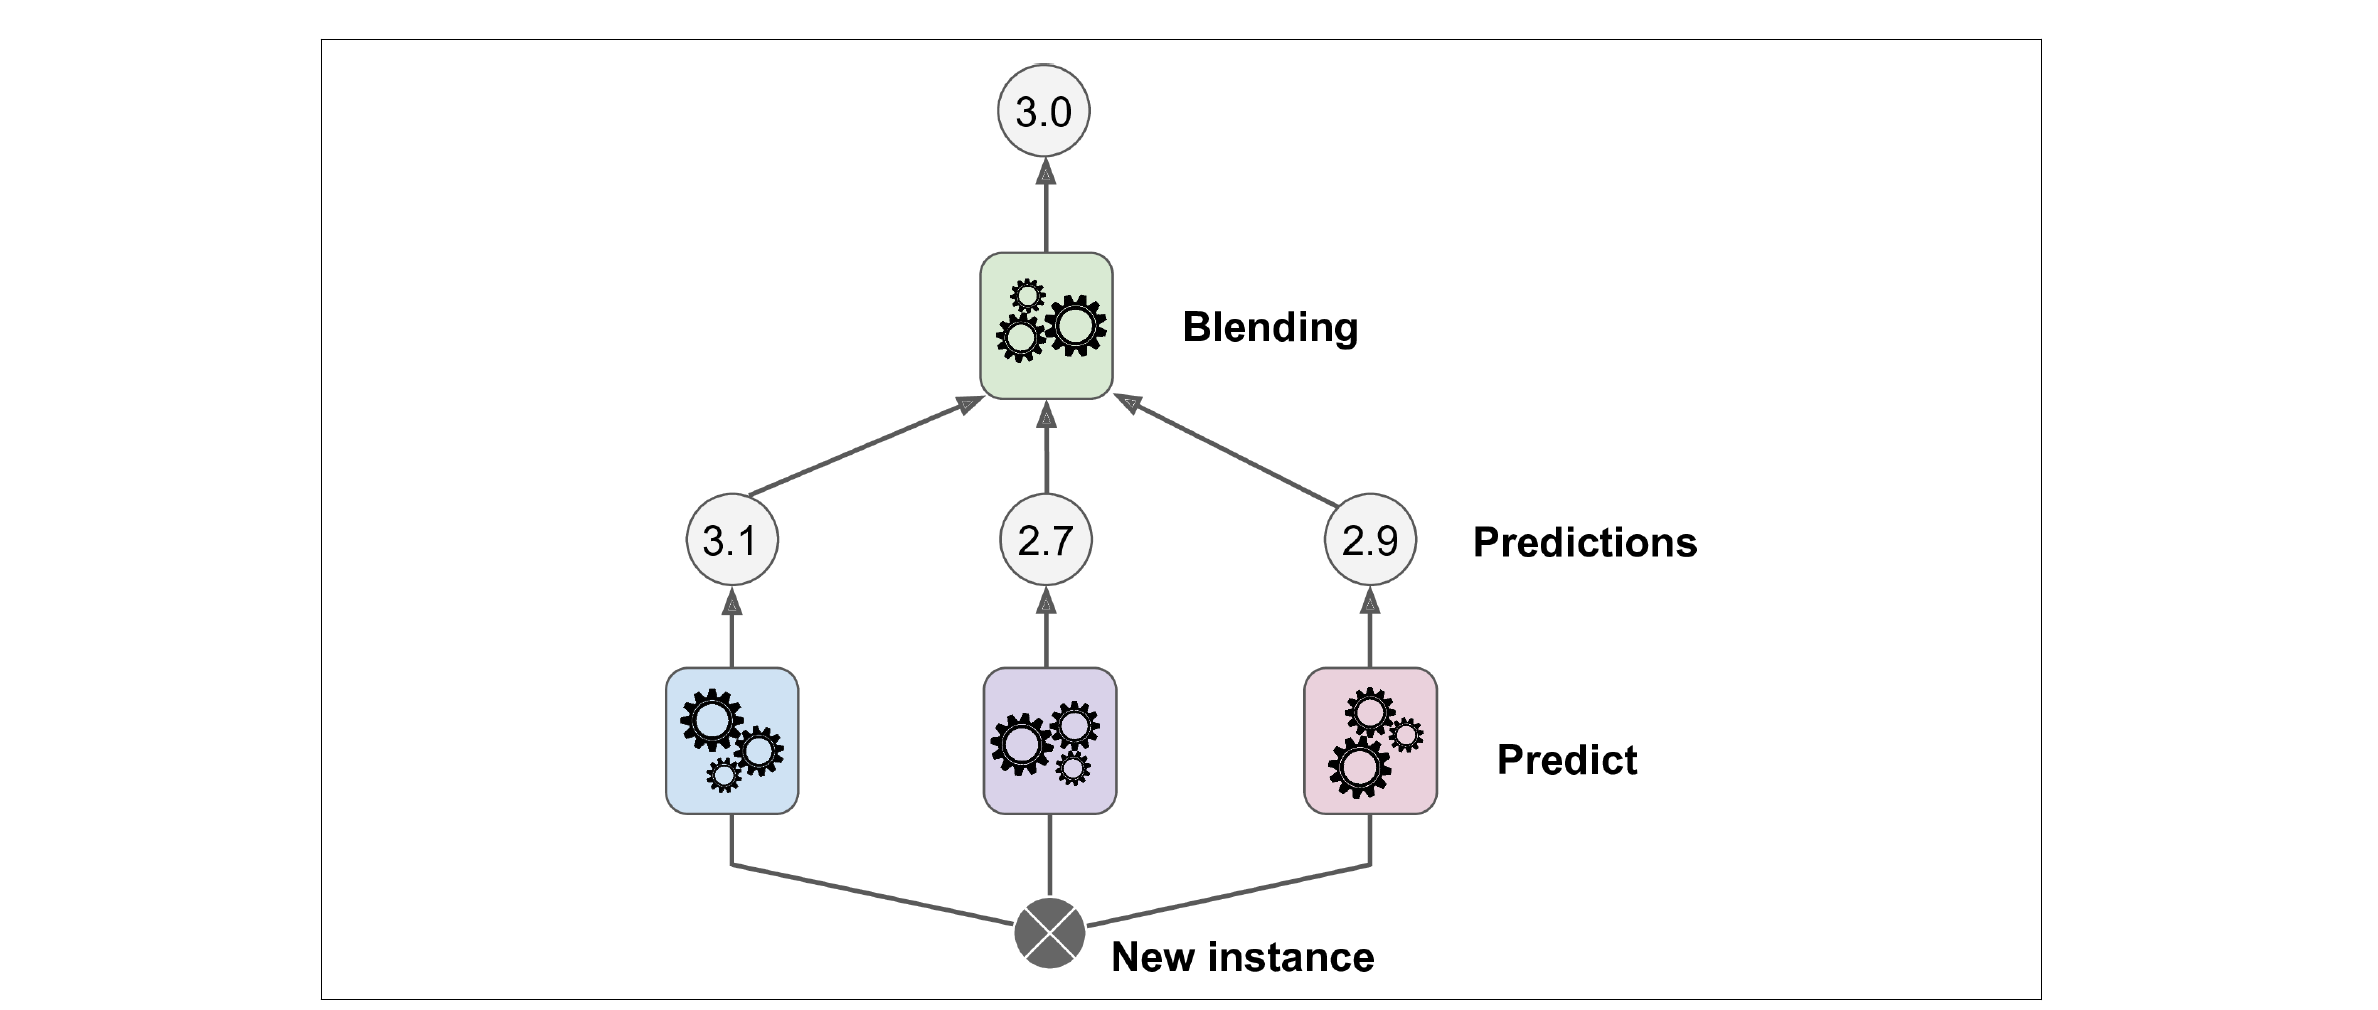

- Each of the bottom three predictors predicts a different value (3.1, 2.7, and 2.9), and then the final predictor (called a **blender, or a meta learner**) takes these predictions as inputs and makes the final prediction (3.0).

- To train the blender, a common approach is to use a **hold-out set**.
    - First, the training set is split in two subsets.
    - The first subset is used to train the predictors in the first layer
    
    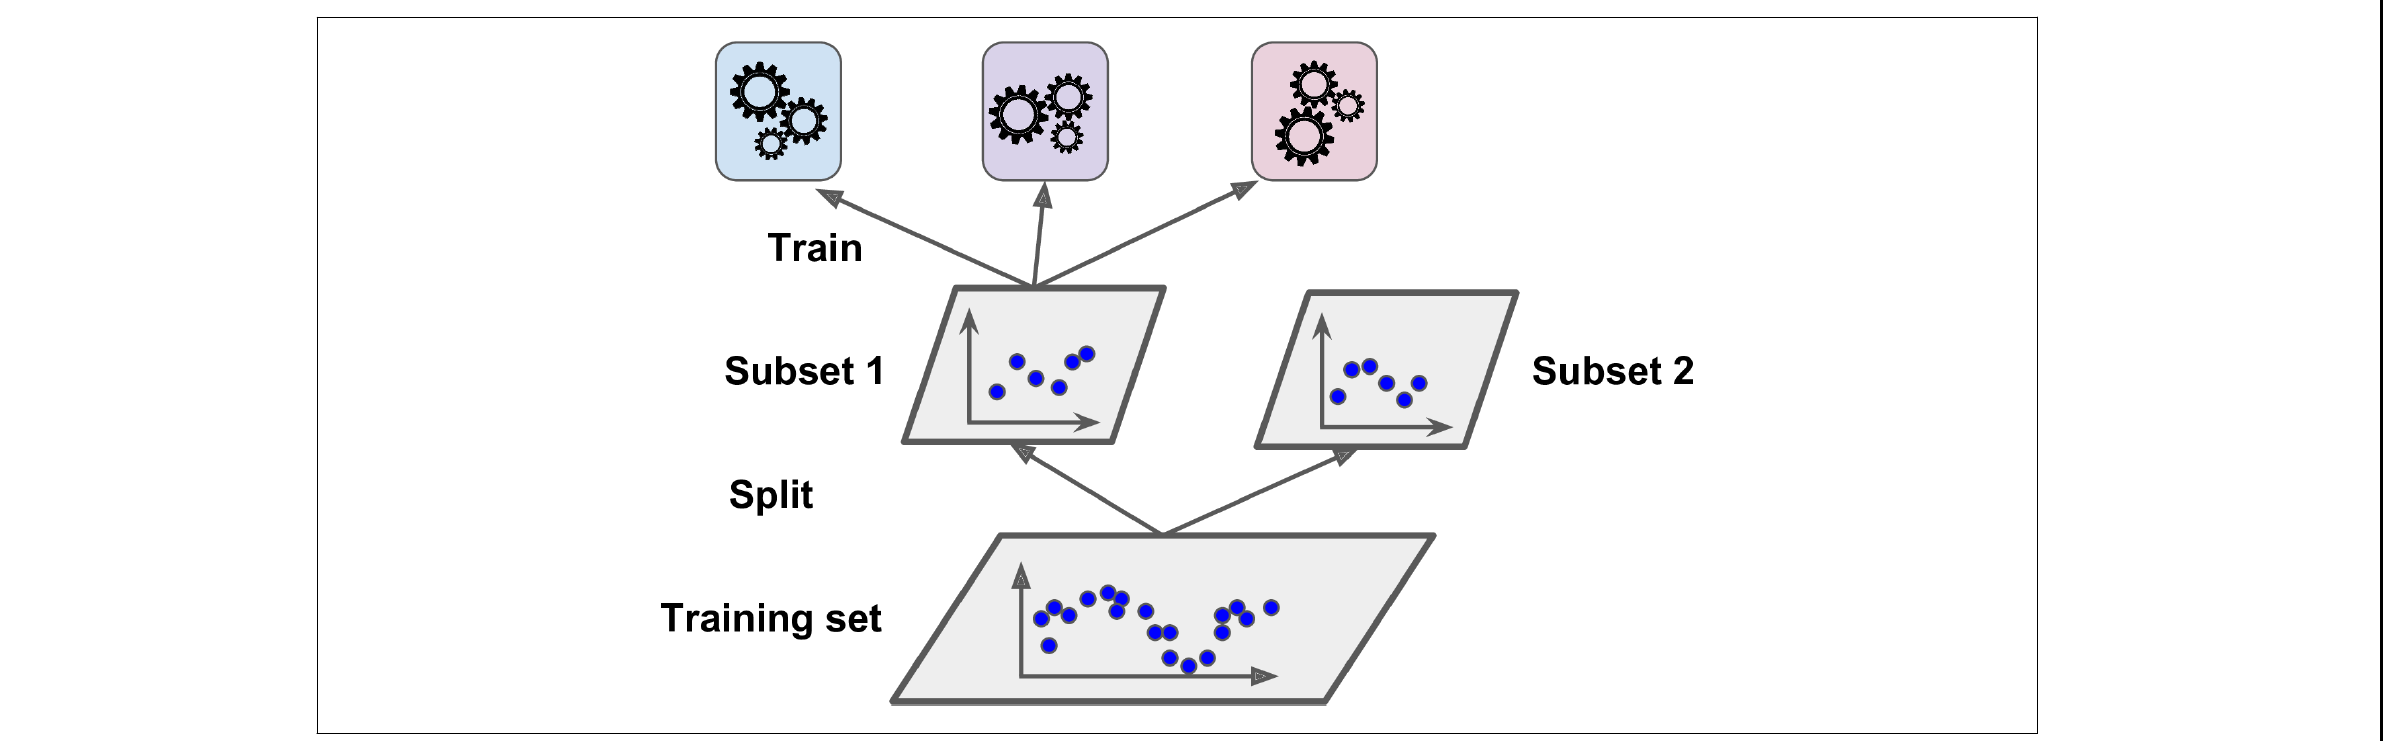
    

   * Next, the first layer predictors are used to make predictions on the second (held-out) set.
   * This ensures that the predictions are “clean,” since the predictors never saw these instances during training.
   * Now for each instance in the hold-out set there are three predicted values. We can create a new training set using these predicted values as input features (which makes this new training set three-dimensional), and keeping the target values.
   * The blender is trained on this new training set, so it learns to predict the target value given the first layer’s predictions.
    
   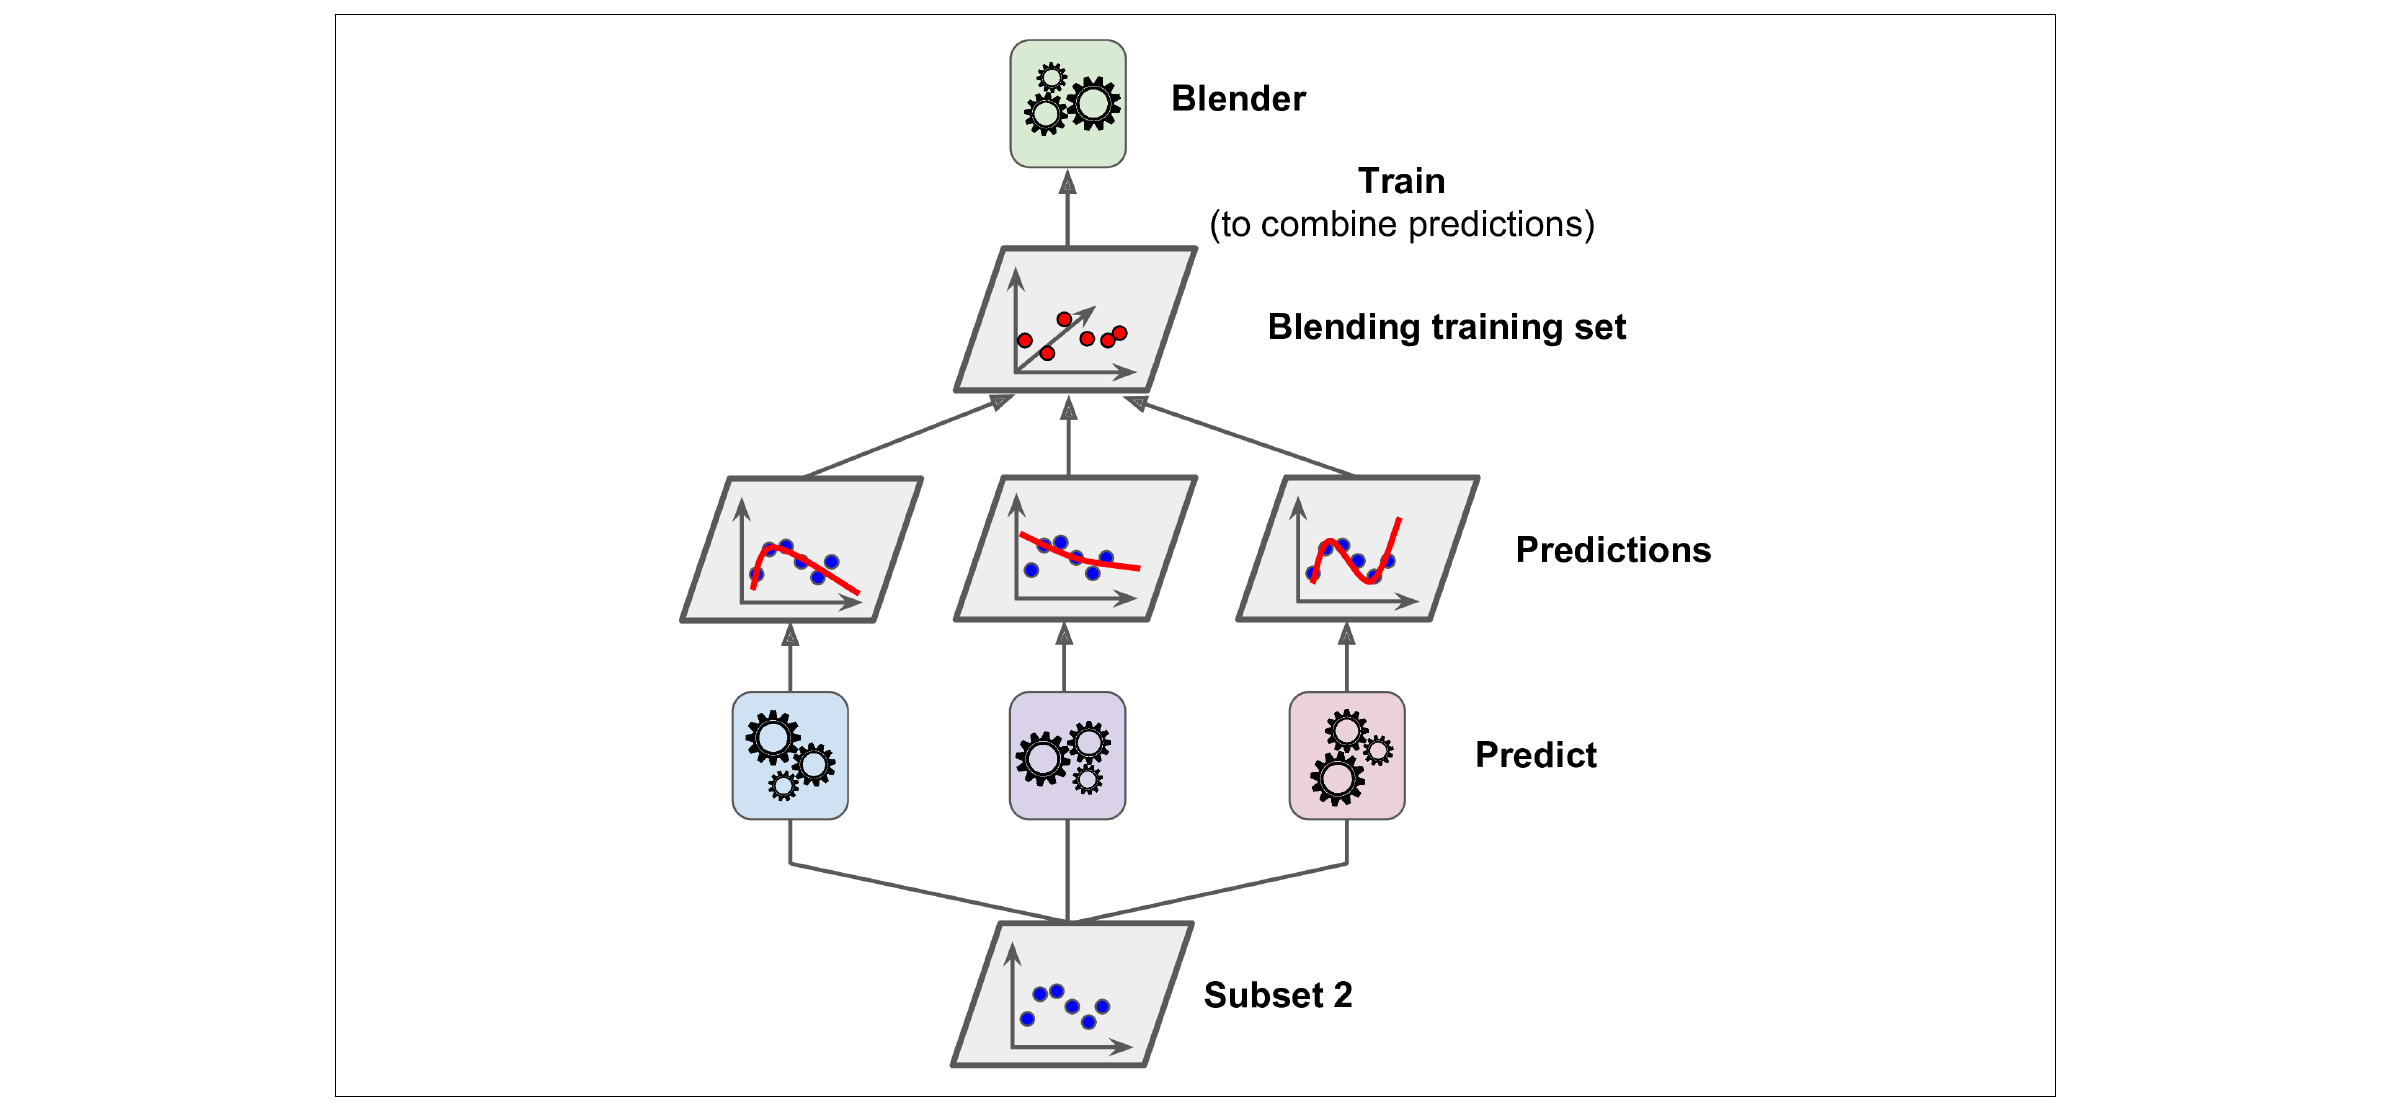

### Even deeper

- It is actually possible to train several different blenders this way (e.g., one using Linear Regression, another using Random Forest Regression, and so on): we get a whole layer of blenders.
- The trick is to split the training set into **three subsets**: the first one is used to train the first layer, the second one is used to create the training set used to train the second layer (using predictions made by the predictors of the first layer), and the third one is used to create the training set to train the third layer (using predictions made by the predictors of the second layer).
- Once this is done, we can make a prediction for a new instance by going through each layer sequentially.

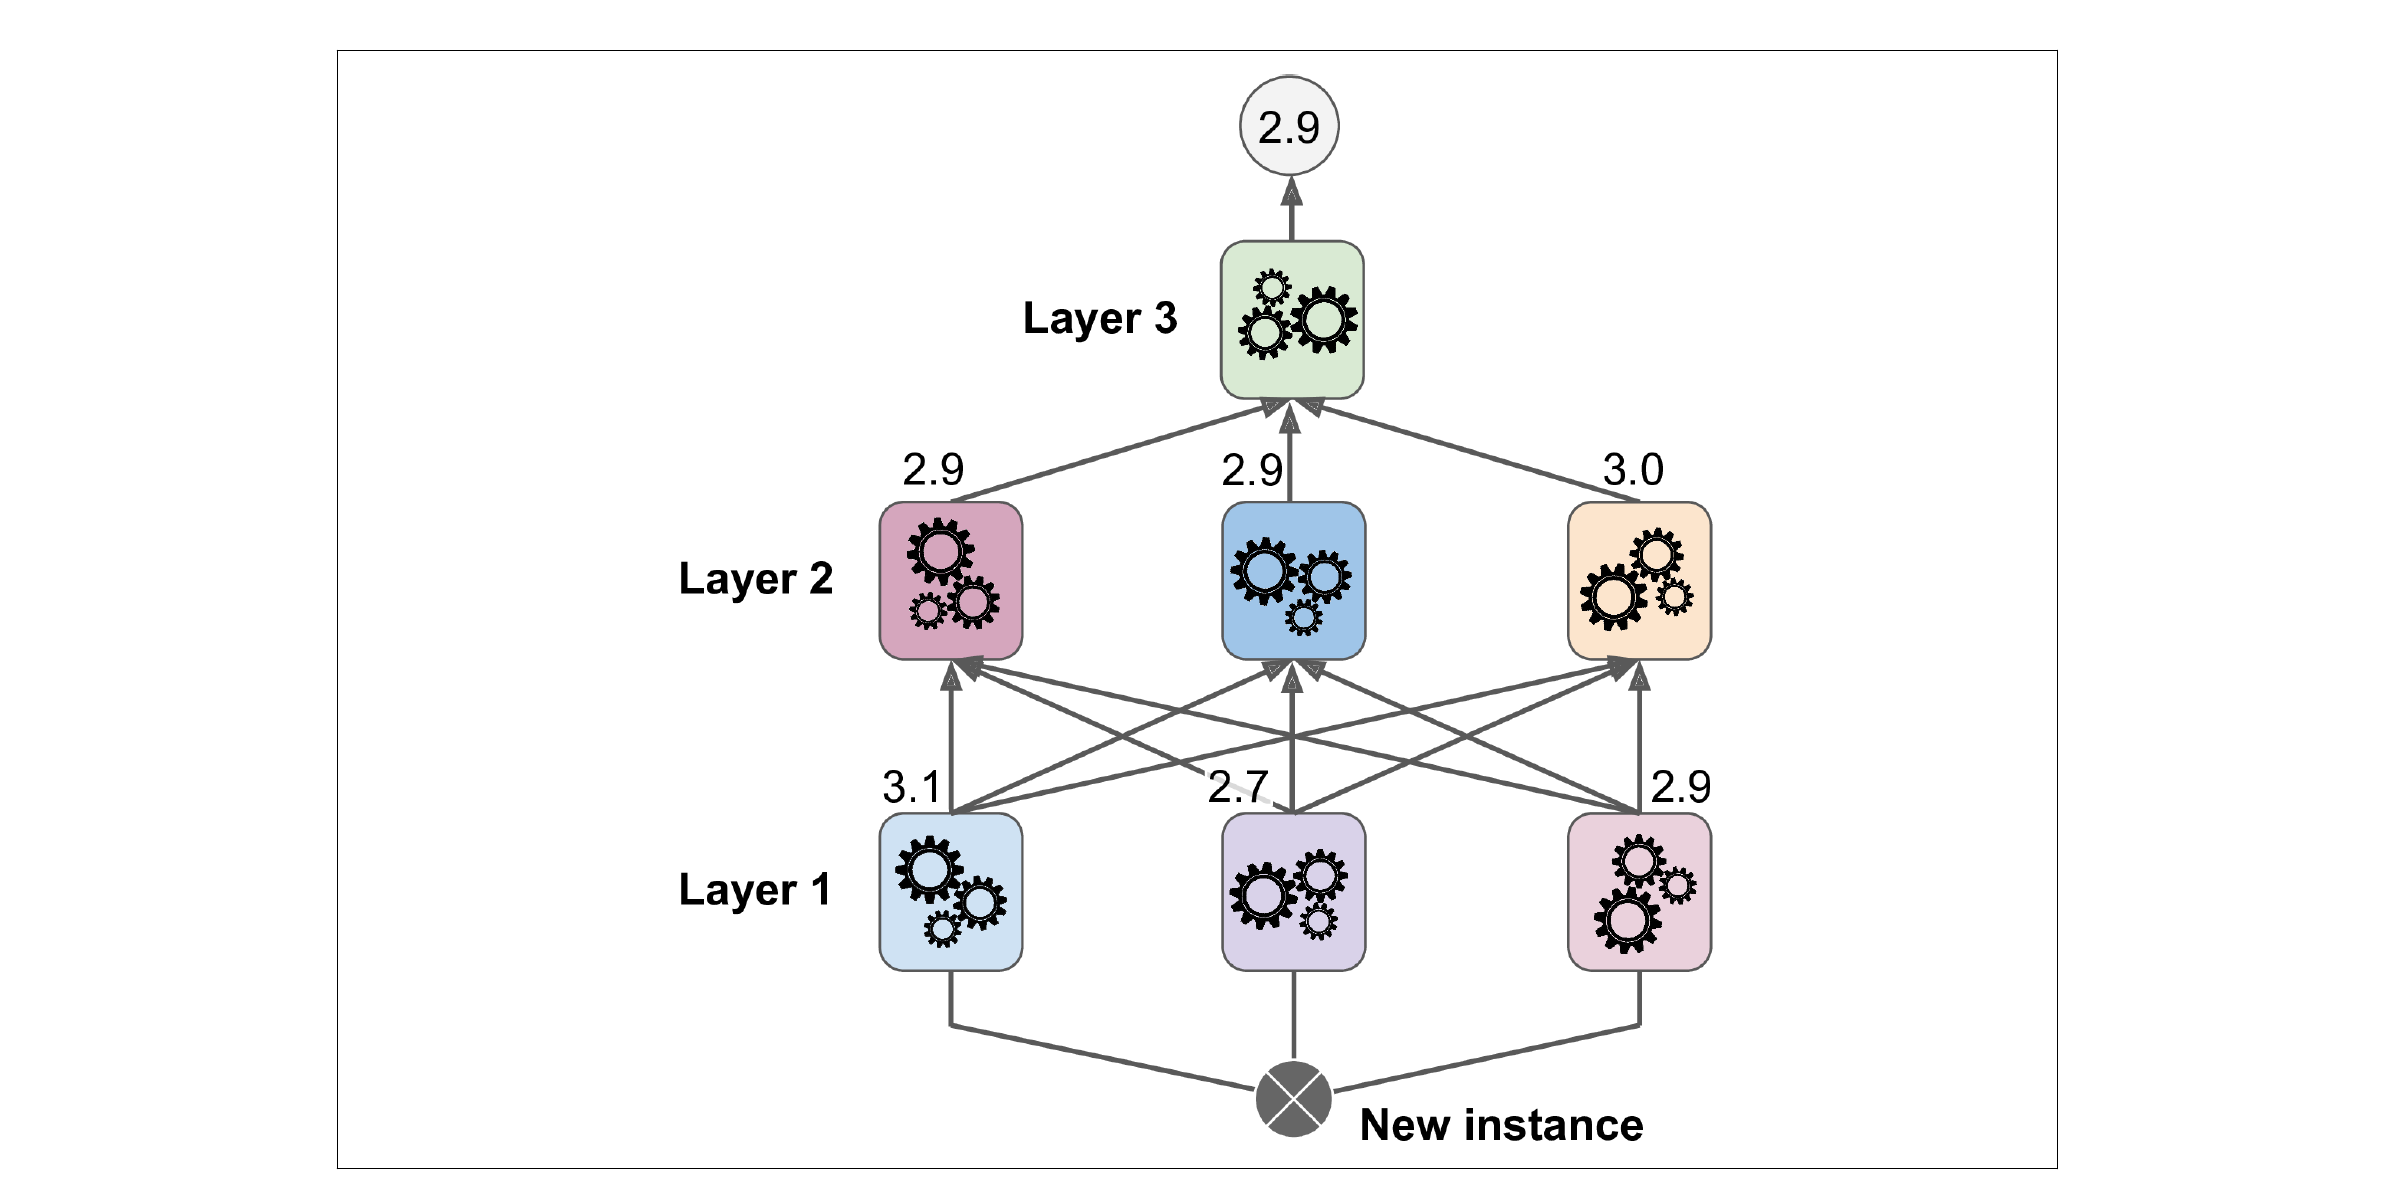

- Stacking is supported by Scikit-learn: `sklearn.ensemble.StackingClassifier`
- Also checkout libraries such as `deslib`!



In [17]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.svm import SVR
estimators = [('ridge', RidgeCV()),
              ('lasso', LassoCV(random_state=42)),
              ('svr', SVR(C=1, gamma=1e-6))]

In [60]:
dir(sklearn.ensemble)

['AdaBoostClassifier',
 'AdaBoostRegressor',
 'BaggingClassifier',
 'BaggingRegressor',
 'BaseEnsemble',
 'ExtraTreesClassifier',
 'ExtraTreesRegressor',
 'GradientBoostingClassifier',
 'GradientBoostingRegressor',
 'IsolationForest',
 'RandomForestClassifier',
 'RandomForestRegressor',
 'RandomTreesEmbedding',
 'VotingClassifier',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_gradient_boosting',
 'bagging',
 'base',
 'forest',
 'gradient_boosting',
 'iforest',
 'partial_dependence',
 'voting_classifier',
 'weight_boosting']

In [18]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=GradientBoostingRegressor(random_state=42))

In [21]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

X, y = load_iris(return_X_y=True)

estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('svr', make_pipeline(StandardScaler(),
                          LinearSVC(random_state=42)))]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

clf.fit(X_train, y_train).score(X_test, y_test)

0.9473684210526315